# Classification

We have here document classification, using basic sklearn and pytorch, and named entity recognition using default settings from spacy and (optionally) Stanford NER. We use a variety of methods and find that:
* Results are very stable between the ground truth and OCRed version of this dataset
* Often, a classifier performs slightly better on the OCRed version of the dataset
* These results are consistent over different text representations (e.g., count vertors, tf-idf, embeddings) and methods (Naive Bayes, SVM, Random Forests, MLP, deeper neural networks)

In [170]:
from glob import glob
import jellyfish
import numpy as np
import os, codecs, re
from tqdm import tqdm
import pandas as pd
from bs4 import BeautifulSoup

In [171]:
%matplotlib inline
import matplotlib.pyplot as plt

# magics and warnings
%load_ext autoreload
%autoreload 2
import warnings; warnings.simplefilter('ignore')

import os, random
from tqdm import tqdm
import pandas as pd
import numpy as np

seed = 99
random.seed(seed)
np.random.seed(seed)

import nltk, gensim, sklearn, spacy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


##### For this analysis we use the DBNL dataset

In [172]:
df = pd.read_csv("data_frames/full_df_DBNL_OCR.csv", compression="gzip")

In [173]:
df.head(1)

,filename,text_ground,genre,subgenre,text_ocr,title,year,edition
0,_vad003182501,\n\n\n\n\n\nBoekbeschouwing.\nDe gemoedsgestel...,"sec - letterkunde,non-fictie",tijdschrift / jaarboek,"SEM1N\t9\n(\tSIS)\ns..\n B OEKBESCHOUWI ' ,\nv...",Vaderlandsche letteroefeningen. Jaargang 1825,1825,1ste druk


In [174]:
df["genre"].value_counts()

sec - letterkunde,non-fictie         77
poëzie                               46
non-fictie                           31
sec - taalkunde                      25
proza,sec - letterkunde              17
proza                                 9
proza,poëzie,non-fictie               5
sec - letterkunde                     3
poëzie,sec - letterkunde              2
poëzie,jeugdliteratuur                2
sec - letterkunde,jeugdliteratuur     1
proza,drama                           1
Name: genre, dtype: int64

In [175]:
def consolidate_classes(original_class):
    "Put together the main classes"
    
    if original_class in ["sec - letterkunde,non-fictie","proza,sec - letterkunde","proza"]:
        return "sec - letterkunde"
    elif "poëzie" in original_class:
        return "poëzie"
    elif original_class == "sec - taalkunde":
        return "sec - taalkunde"
    elif original_class == "non-fictie":
        return "non-fictie"
    return np.nan

In [176]:
%%time
# test the speed of the levenshtein distance

jellyfish.levenshtein_distance(df["text_ground"].values[0][:1000],df["text_ocr"].values[0][:1000])

CPU times: user 2.7 ms, sys: 295 µs, total: 3 ms
Wall time: 3.05 ms


869

In [177]:
df["consolidated_genre"] = df["genre"].apply(consolidate_classes)

In [178]:
df.head(1)

,filename,text_ground,genre,subgenre,text_ocr,title,year,edition,consolidated_genre
0,_vad003182501,\n\n\n\n\n\nBoekbeschouwing.\nDe gemoedsgestel...,"sec - letterkunde,non-fictie",tijdschrift / jaarboek,"SEM1N\t9\n(\tSIS)\ns..\n B OEKBESCHOUWI ' ,\nv...",Vaderlandsche letteroefeningen. Jaargang 1825,1825,1ste druk,sec - letterkunde


In [179]:
df.dropna(subset=['consolidated_genre'], inplace=True)

In [180]:
df.shape

(214, 9)

### Setup and pre-processing

In [136]:
!python -m spacy download nl

     |████████████████████████████████| 36.7 MB 2.7 MB/s eta 0:00:01

    Linking successful
    /anaconda3/envs/ocr_lm/lib/python3.7/site-packages/nl_core_news_sm -->
    /anaconda3/envs/ocr_lm/lib/python3.7/site-packages/spacy/data/nl

    You can now load the model via spacy.load('nl')



In [181]:
sample_ground = df["text_ground"].values
sample_ocr = df["text_ocr"].values
labels = df["consolidated_genre"].values

In [182]:
print(len(sample_ground))

214


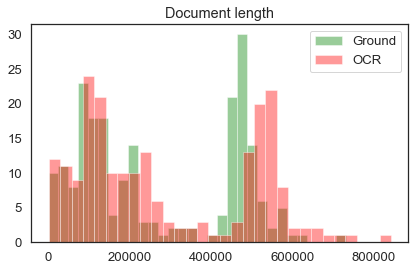

In [183]:
sns.distplot([len(x.split()) for x in sample_ground], label="Ground", kde=False, color="green", bins=30)
sns.distplot([len(x.split()) for x in sample_ocr], label="OCR", kde=False, color="red", bins=30)
plt.title("Document length")
plt.legend()
plt.tight_layout()

In [184]:
# trim the number of characters in use for each document

LIMIT = 100000

sample_ground = [x[:LIMIT] for x in sample_ground]
sample_ocr = [x[:LIMIT] for x in sample_ocr]

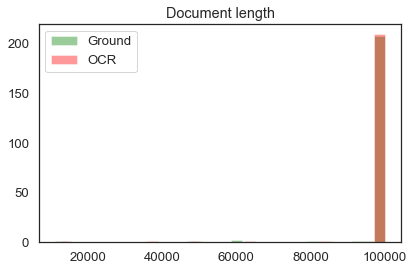

In [185]:
sns.distplot([len(x) for x in sample_ground], label="Ground", kde=False, color="green", bins=30)
sns.distplot([len(x) for x in sample_ocr], label="OCR", kde=False, color="red", bins=30)
plt.title("Document length")
plt.legend()
plt.tight_layout()

#### Pre-processing
We apply a canonical pre-processing pipeline, including the following steps:

* Remove stop-words
* Lemmatize
* Lowercase
* Remove tokens shorter than 3 characters

In [22]:
nlp = spacy.load('nl')
STOPWORDS = spacy.lang.nl.stop_words.STOP_WORDS
STOPWORDS.add("eene")

In [23]:
%%time

processed_docs = list()
for doc in nlp.pipe(sample_ocr, n_threads=5, batch_size=10):

    # Process document using Spacy NLP pipeline.
    #ents = doc.ents  # Named entities

    # Keep only words (no numbers, no punctuation).
    # Lemmatize tokens, remove punctuation and remove stopwords.
    doc = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]

    # Remove common words from a stopword list and keep only words of length 3 or more.
    doc = [token.lower() for token in doc if token not in STOPWORDS and len(token) > 2]

    # Add named entities, but only if they are a compound of more than one word.
    #doc.extend([str(entity) for entity in ents if len(entity) > 1])

    processed_docs.append(doc)

CPU times: user 17min 39s, sys: 4min 55s, total: 22min 35s
Wall time: 15min 21s


In [25]:
docs = processed_docs
del processed_docs

In [26]:
# You will need to run the same pipeline twice, for ground truth and OCR documents. Comment/uncomment this part each time:
#docs_ground = docs
docs_ocr = docs

In [134]:
# save corpora
import pickle

with open('folder_classification/docs_ground.pkl', 'wb') as handle:
    pickle.dump(docs_ground, handle)
with open('folder_classification/docs_ocr.pkl', 'wb') as handle:
    pickle.dump(docs_ocr, handle)
with open('folder_classification/labels.pkl', 'wb') as handle:
    pickle.dump(labels, handle)

#### Start from the pre-processed corpus

In [186]:
# load corpora
import pickle

docs_ground = list()
docs_ocr = list()
labels = list()

with open('folder_classification/docs_ground.pkl', 'rb') as handle:
    docs_ground = pickle.load(handle)
with open('folder_classification/docs_ocr.pkl', 'rb') as handle:
    docs_ocr = pickle.load(handle)
with open('folder_classification/labels.pkl', 'rb') as handle:
    labels = pickle.load(handle)

In [187]:
docs_ground[0][:10]

['boekbeschouwing',
 'gemoedsgesteldheid',
 'david',
 'onder',
 'zijne',
 'verschillende',
 'lotgevallen',
 'zijne',
 'psalmen',
 'opgemaakt']

In [188]:
docs_ocr[0][:10]

['sis',
 'oekbeschouwi',
 'voor',
 'erland',
 'scfie',
 'letteroefeningen',
 'tij',
 'schr',
 'van',
 'kunsten']

## Simple classifiers with Sklearn

In [189]:
from collections import Counter

# these are the labels
c = Counter(labels)
c

Counter({'sec - letterkunde': 103,
         'sec - taalkunde': 25,
         'non-fictie': 31,
         'poëzie': 55})

In [190]:
# train/test split
from sklearn.model_selection import train_test_split

train_g, test_g, labels_train_g, labels_test_g = train_test_split(docs_ground, labels, test_size=0.2, random_state=seed)
train_o, test_o, labels_train_o, labels_test_o = train_test_split(docs_ocr, labels, test_size=0.2, random_state=seed)

In [191]:
# save as csv (used later on for PyTorch)

with open('folder_classification/train_g.csv', 'w') as handle:
    for t,l in zip(train_g,labels_train_g):
        handle.write("\""+" ".join(t)+"\","+l+"\n")
with open('folder_classification/train_o.csv', 'w') as handle:
    for t,l in zip(train_o,labels_train_o):
        handle.write("\""+" ".join(t)+"\","+l+"\n")
with open('folder_classification/test_g.csv', 'w') as handle:
    for t,l in zip(test_g,labels_test_g):
        handle.write("\""+" ".join(t)+"\","+l+"\n")
with open('folder_classification/test_o.csv', 'w') as handle:
    for t,l in zip(test_o,labels_test_o):
        handle.write("\""+" ".join(t)+"\","+l+"\n")

In [192]:
# Feature extractors

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# remove terms only in one doc and turn off prepocessing (which we did already)
count_vect_g = CountVectorizer(min_df=2, analyzer=lambda x: x)
tfidf_vect_g = TfidfVectorizer(min_df=2, analyzer=lambda x: x) 
count_vect_o = CountVectorizer(min_df=2, analyzer=lambda x: x) 
tfidf_vect_o = TfidfVectorizer(min_df=2, analyzer=lambda x: x) 

count_tr_g = count_vect_g.fit(train_g)
count_tr_o = count_vect_o.fit(train_o)
tfidf_tr_g = tfidf_vect_g.fit(train_g)
tfidf_tr_o = tfidf_vect_o.fit(train_o)

X_train_g_counts = count_tr_g.transform(train_g)
X_train_g_counts.shape
X_train_o_counts = count_tr_o.transform(train_o)
X_train_o_counts.shape

X_train_g_tfidf = tfidf_tr_g.transform(train_g)
X_train_o_tfidf = tfidf_tr_o.transform(train_o)
X_train_o_tfidf.shape

(171, 58477)

In [193]:
X_train_g_tfidf.shape

(171, 54907)

### Baseline classifiers: NB, SVC, RF, MLP

#### Count-based features

In [194]:
classifiers = list()

In [195]:
from sklearn.naive_bayes import MultinomialNB

clf_g_NB = MultinomialNB().fit(X_train_g_counts, labels_train_g)
clf_o_NB = MultinomialNB().fit(X_train_o_counts, labels_train_o)
classifiers.append(("NB",clf_g_NB,clf_o_NB))

In [196]:
from sklearn import svm

clf_g_SVM = svm.SVC(decision_function_shape='ovr').fit(X_train_g_counts, labels_train_g)
clf_o_SVM = svm.SVC(decision_function_shape='ovr').fit(X_train_o_counts, labels_train_o)
classifiers.append(("SVM",clf_g_SVM,clf_o_SVM))

In [197]:
from sklearn.ensemble import RandomForestClassifier

clf_g_RF = RandomForestClassifier(max_depth=10, n_estimators=20, max_features=100).fit(X_train_g_counts, labels_train_g)
clf_o_RF = RandomForestClassifier(max_depth=10, n_estimators=20, max_features=100).fit(X_train_o_counts, labels_train_o)
classifiers.append(("RF",clf_g_RF,clf_o_RF))

In [198]:
from sklearn.neural_network import MLPClassifier

clf_g_MLP = MLPClassifier(hidden_layer_sizes=(100, 50, 25)).fit(X_train_g_counts, labels_train_g)
clf_o_MLP = MLPClassifier(hidden_layer_sizes=(100, 50, 25)).fit(X_train_o_counts, labels_train_o)
classifiers.append(("MLP",clf_g_MLP,clf_o_MLP))

##### Ground truth

In [199]:
from sklearn import metrics
X_test_g_counts = count_tr_g.transform(test_g)

print("Ground truth\n------\n")
for cl in classifiers:
    print(cl[0])
    predicted = cl[1].predict(X_test_g_counts)
    print(np.mean(predicted == labels_test_g))
    print(metrics.classification_report(labels_test_g, predicted))
    print(metrics.confusion_matrix(labels_test_g, predicted))
    print("\n------\n")

Ground truth
------

NB
0.8604651162790697
                   precision    recall  f1-score   support

       non-fictie       1.00      0.86      0.92         7
           poëzie       0.85      0.73      0.79        15
sec - letterkunde       0.81      1.00      0.89        17
  sec - taalkunde       1.00      0.75      0.86         4

         accuracy                           0.86        43
        macro avg       0.91      0.84      0.87        43
     weighted avg       0.87      0.86      0.86        43

[[ 6  1  0  0]
 [ 0 11  4  0]
 [ 0  0 17  0]
 [ 0  1  0  3]]

------

SVM
0.813953488372093
                   precision    recall  f1-score   support

       non-fictie       1.00      0.86      0.92         7
           poëzie       0.82      0.60      0.69        15
sec - letterkunde       0.74      1.00      0.85        17
  sec - taalkunde       1.00      0.75      0.86         4

         accuracy                           0.81        43
        macro avg       0.89      

##### OCR

In [200]:
X_test_o_counts = count_tr_o.transform(test_o)

print("OCR\n------\n")
for cl in classifiers:
    print(cl[0])
    predicted = cl[2].predict(X_test_o_counts)
    print(np.mean(predicted == labels_test_o))
    print(metrics.classification_report(labels_test_o, predicted))
    print(metrics.confusion_matrix(labels_test_o, predicted))
    print("\n------\n")

OCR
------

NB
0.8837209302325582
                   precision    recall  f1-score   support

       non-fictie       1.00      0.86      0.92         7
           poëzie       0.86      0.80      0.83        15
sec - letterkunde       0.85      1.00      0.92        17
  sec - taalkunde       1.00      0.75      0.86         4

         accuracy                           0.88        43
        macro avg       0.93      0.85      0.88        43
     weighted avg       0.89      0.88      0.88        43

[[ 6  1  0  0]
 [ 0 12  3  0]
 [ 0  0 17  0]
 [ 0  1  0  3]]

------

SVM
0.8604651162790697
                   precision    recall  f1-score   support

       non-fictie       1.00      0.86      0.92         7
           poëzie       0.85      0.73      0.79        15
sec - letterkunde       0.81      1.00      0.89        17
  sec - taalkunde       1.00      0.75      0.86         4

         accuracy                           0.86        43
        macro avg       0.91      0.84    

#### Tf-Idf features

In [201]:
classifiers = list()

In [202]:
from sklearn.naive_bayes import MultinomialNB

clf_g_NB = MultinomialNB().fit(X_train_g_tfidf, labels_train_g)
clf_o_NB = MultinomialNB().fit(X_train_o_tfidf, labels_train_o)
classifiers.append(("NB",clf_g_NB,clf_o_NB))

In [203]:
from sklearn import svm

clf_g_SVM = svm.SVC(gamma=2, C=1, decision_function_shape='ovr').fit(X_train_g_tfidf, labels_train_g)
clf_o_SVM = svm.SVC(gamma=2, C=1, decision_function_shape='ovr').fit(X_train_o_tfidf, labels_train_o)
classifiers.append(("SVM",clf_g_SVM,clf_o_SVM))

In [204]:
from sklearn.ensemble import RandomForestClassifier

clf_g_RF = RandomForestClassifier(max_depth=10, n_estimators=20, max_features=100).fit(X_train_g_tfidf, labels_train_g)
clf_o_RF = RandomForestClassifier(max_depth=10, n_estimators=20, max_features=100).fit(X_train_o_tfidf, labels_train_o)
classifiers.append(("RF",clf_g_RF,clf_o_RF))

In [205]:
from sklearn.neural_network import MLPClassifier

clf_g_MLP = MLPClassifier(hidden_layer_sizes=(100, 50, 25)).fit(X_train_g_tfidf, labels_train_g)
clf_o_MLP = MLPClassifier(hidden_layer_sizes=(100, 50, 25)).fit(X_train_o_tfidf, labels_train_o)
classifiers.append(("MLP",clf_g_MLP,clf_o_MLP))

##### Ground truth

In [206]:
from sklearn import metrics
X_test_g_tfidf = tfidf_tr_g.transform(test_g)

print("Ground truth\n------\n")
for cl in classifiers:
    print(cl[0])
    predicted = cl[1].predict(X_test_g_tfidf)
    print(np.mean(predicted == labels_test_g))
    print(metrics.classification_report(labels_test_g, predicted))
    print(metrics.confusion_matrix(labels_test_g, predicted))
    print("\n------\n")

Ground truth
------

NB
0.4186046511627907
                   precision    recall  f1-score   support

       non-fictie       0.00      0.00      0.00         7
           poëzie       1.00      0.07      0.12        15
sec - letterkunde       0.40      1.00      0.58        17
  sec - taalkunde       0.00      0.00      0.00         4

         accuracy                           0.42        43
        macro avg       0.35      0.27      0.18        43
     weighted avg       0.51      0.42      0.27        43

[[ 0  0  7  0]
 [ 0  1 14  0]
 [ 0  0 17  0]
 [ 0  0  4  0]]

------

SVM
0.7906976744186046
                   precision    recall  f1-score   support

       non-fictie       1.00      0.86      0.92         7
           poëzie       0.82      0.60      0.69        15
sec - letterkunde       0.71      1.00      0.83        17
  sec - taalkunde       1.00      0.50      0.67         4

         accuracy                           0.79        43
        macro avg       0.88     

##### OCR

In [207]:
X_test_o_tfidf = tfidf_tr_o.transform(test_o)

print("OCR\n------\n")
for cl in classifiers:
    print(cl[0])
    predicted = cl[2].predict(X_test_o_tfidf)
    print(np.mean(predicted == labels_test_o))
    print(metrics.classification_report(labels_test_o, predicted))
    print(metrics.confusion_matrix(labels_test_o, predicted))
    print("\n------\n")

Ground truth
------

NB
0.4186046511627907
                   precision    recall  f1-score   support

       non-fictie       0.00      0.00      0.00         7
           poëzie       1.00      0.07      0.12        15
sec - letterkunde       0.40      1.00      0.58        17
  sec - taalkunde       0.00      0.00      0.00         4

         accuracy                           0.42        43
        macro avg       0.35      0.27      0.18        43
     weighted avg       0.51      0.42      0.27        43

[[ 0  0  7  0]
 [ 0  1 14  0]
 [ 0  0 17  0]
 [ 0  0  4  0]]

------

SVM
0.7674418604651163
                   precision    recall  f1-score   support

       non-fictie       1.00      0.86      0.92         7
           poëzie       0.83      0.67      0.74        15
sec - letterkunde       0.68      1.00      0.81        17
  sec - taalkunde       0.00      0.00      0.00         4

         accuracy                           0.77        43
        macro avg       0.63     

---

## PyTorch

We here use a more advanced classifier based on neural networks, using PyTorch.

In [208]:
import torch
import torchtext
from torchtext import data

In [209]:
# load data

from torchtext.data import Field, LabelField

tokenize = lambda x: x.split()
TEXT_g = Field(sequential=True, tokenize=tokenize, lower=False)
LABEL_g = LabelField(sequential=False)
datafields_g = [("text", TEXT_g), ("label", LABEL_g)]

TEXT_o = Field(sequential=True, tokenize=tokenize, lower=False)
LABEL_o = LabelField(sequential=False)
datafields_o = [("text", TEXT_o), ("label", LABEL_o)]

torch_train_g, torch_test_g = data.TabularDataset.splits(
               path="folder_classification", # the root directory where the data lies
               train='train_g.csv', validation="test_g.csv",
               format='csv',
               skip_header=False,
               fields=datafields_g)
torch_train_o, torch_test_o = data.TabularDataset.splits(
               path="folder_classification", # the root directory where the data lies
               train='train_o.csv', validation="test_o.csv",
               format='csv',
               skip_header=False,
               fields=datafields_o)

In [210]:
# build vocabs
TEXT_g.build_vocab(torch_train_g)
TEXT_o.build_vocab(torch_train_o)
LABEL_g.build_vocab(torch_train_g)
LABEL_o.build_vocab(torch_train_o)

In [211]:
LABEL_g.vocab.freqs

Counter({'sec - letterkunde': 86,
         'poëzie': 40,
         'non-fictie': 24,
         'sec - taalkunde': 21})

In [212]:
LABEL_g.vocab.stoi

defaultdict(None,
            {'sec - letterkunde': 0,
             'poëzie': 1,
             'non-fictie': 2,
             'sec - taalkunde': 3})

In [213]:
torch_train_g[0].__dict__.keys()

dict_keys(['text', 'label'])

In [214]:
torch_train_g[0].label

'sec - letterkunde'

In [215]:
torch_train_g[0].text[:10]

['boekbeschouwing',
 'voorlezingen',
 'geschiedenis',
 'opvoeding',
 'des',
 'menschdoms',
 'god',
 'komst',
 'jezus',
 'christus']

In [216]:
# define model
# This one is largely taken from: https://pytorch.org/tutorials/beginner/text_sentiment_ngrams_tutorial.html

import torch.nn as nn
import torch.nn.functional as F

class TextClass(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super().__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=False) # embedding bag + linear layer method. With sparese=True we need to use SparseAdam below
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text):
        embedded = self.embedding(text.permute(1, 0))
        preds = self.fc(embedded)
        #preds = F.log_softmax(preds, dim=-1) #NB to be removed for some losses!
        return preds

# from: https://mlexplained.com/2018/02/08/a-comprehensive-tutorial-to-torchtext/
class SimpleLSTMBaseline(nn.Module):
    def __init__(self, vocab_size, hidden_dim, emb_dim, num_class, num_linear=1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim)
        self.encoder = nn.LSTM(emb_dim, hidden_dim, num_layers=1)
        self.linear_layers = []
        for _ in range(num_linear - 1):
            self.linear_layers.append(nn.Linear(hidden_dim, hidden_dim))
            self.linear_layers = nn.ModuleList(self.linear_layers)
        self.fc = nn.Linear(hidden_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, seq):
        hdn, _ = self.encoder(self.embedding(seq))
        feature = hdn[-1, :, :]
        for layer in self.linear_layers:
            feature = layer(feature)
        preds = self.fc(feature)
        #preds = F.log_softmax(preds, dim=-1) #NB to be removed for some losses!
        return preds

In [217]:
BATCH_SIZE = 15
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### Train and test

Choose here which version of the dataset to use.

In [249]:
WHICH_DATASET = "ground" # "ocr" "ground"
VOCAB_SIZE = len(TEXT_g.vocab)
if WHICH_DATASET == "ocr":
    VOCAB_SIZE = len(TEXT_o.vocab)
EMBED_DIM = 128
HIDDEN_DIM = 256
NUM_CLASS = len(c)
model = TextClass(VOCAB_SIZE, EMBED_DIM, NUM_CLASS).to(device)

In [250]:
c

Counter({'sec - letterkunde': 103,
         'sec - taalkunde': 25,
         'non-fictie': 31,
         'poëzie': 55})

In [251]:
NUM_CLASS

4

In [252]:
# iterators
# largely from: https://mlexplained.com/2018/02/08/a-comprehensive-tutorial-to-torchtext/

from torchtext.data import Iterator, BucketIterator

train_g_iter, test_g_iter = BucketIterator.splits(
    (torch_train_g, torch_test_g), # we pass in the datasets we want the iterator to draw data from
    batch_sizes=(BATCH_SIZE, BATCH_SIZE),
    device=device, # if you want to use the GPU, specify the GPU number here
    sort_key=lambda x: len(x.text), # the BucketIterator needs to be told what function it should use to group the data.
    sort_within_batch=False,
    repeat=False # we pass repeat=False because we want to wrap this Iterator layer.
)
train_o_iter, test_o_iter = BucketIterator.splits(
    (torch_train_o, torch_test_o), # we pass in the datasets we want the iterator to draw data from
    batch_sizes=(BATCH_SIZE, BATCH_SIZE),
    device=device, # if you want to use the GPU, specify the GPU number here
    sort_key=lambda x: len(x.text), # the BucketIterator needs to be told what function it should use to group the data.
    sort_within_batch=False,
    repeat=False # we pass repeat=False because we want to wrap this Iterator layer.
)

In [253]:
batch_test = next(iter(train_g_iter))

In [254]:
batch_test.text

tensor([[  4502,    229,   9844,  ...,    125,    127,   5385],
        [   554,    582,  10197,  ...,    229,   1040,     25],
        [ 26358,   1048,   2275,  ...,    582,    260,    514],
        ...,
        [     1,      1,      1,  ...,      1,      1,    928],
        [     1,      1,      1,  ...,      1,      1,   9045],
        [     1,      1,      1,  ...,      1,      1, 115133]])

In [255]:
batch_test.label

tensor([0, 0, 3, 2, 2, 2, 0, 1, 1, 0, 0, 0, 0, 1, 1])

In [256]:
class BatchWrapper:
    def __init__(self, dl, x_var, y_var):
        self.dl, self.x_var, self.y_var = dl, x_var, y_var # we pass in the list of attributes for x 

    def __iter__(self):
        for batch in self.dl:
            x = getattr(batch, self.x_var) # we assume only one input in this wrapper
            y = getattr(batch, self.y_var)
            
            """
            if self.y_vars is not None: # we will concatenate y into a single tensor
                y = torch.cat([getattr(batch, feat).unsqueeze(1) for feat in self.y_vars], dim=1).float()
            else:
                y = torch.zeros((1))
            """
            
            yield (x, y)

    def __len__(self):
        return len(self.dl)

In [257]:
TRAIN_LEN = len(torch_train_g)
TEST_LEN = len(torch_test_g)
train_dl = BatchWrapper(train_g_iter, "text", "label")
test_dl = BatchWrapper(test_g_iter, "text", "label")
if WHICH_DATASET == "ocr":
    TRAIN_LEN = len(torch_train_o)
    TEST_LEN = len(torch_test_o)
    train_dl = BatchWrapper(train_o_iter, "text", "label")
    test_dl = BatchWrapper(test_o_iter, "text", "label")

In [258]:
# train

import tqdm
import torch.optim as optim
from torch.autograd import Variable

opt = optim.Adam(model.parameters(), lr=1e-2)
#loss_func = nn.BCEWithLogitsLoss()
loss_func = nn.CrossEntropyLoss()
#loss_func = nn.NLLLoss()

epochs = 10

for epoch in range(1, epochs + 1):
    running_loss = 0.0
    train_acc = 0.0
    running_batch = 1
    model.train() # turn on training mode
    for x, y in tqdm.tqdm_notebook(train_dl): # thanks to our wrapper, we can intuitively iterate over our data!
        opt.zero_grad()
        #print(x.shape)

        preds = model(x)
        #print(preds.shape)
        #print(y.view(-1,1).shape)
        #print(y.view(-1,1).dtype)
        #print(y.view(-1,1))
        #print(preds)
        loss = loss_func(preds,y)
        loss.backward()
        opt.step()

        running_loss += loss.item()
        train_acc += (preds.argmax(1) == y).sum().item()
        #print('Batch Training loss: {:.4f}, Train acc: {:.4f}.'.format(loss.item(), train_acc / (BATCH_SIZE*running_batch)))
        #running_loss += loss.data * x.size(0)
        
        running_batch += 1

    epoch_loss = running_loss / TRAIN_LEN

    # calculate the validation loss for this epoch
    val_loss = 0.0
    val_acc = 0.0
    model.eval() # turn on evaluation mode
    for x, y in test_dl:
        preds = model(x)
        #print(preds)
        #print(y)
        loss = loss_func(preds,y)
        val_loss += loss.item()
        val_acc += (preds.argmax(1) == y).sum().item()

    val_loss /= TEST_LEN
    print('Epoch: {}, Training Loss: {:.4f}, Validation Loss: {:.4f}; Train acc: {:.4f}, Validation acc: {:.4f}.'.format(epoch, epoch_loss, val_loss, train_acc/TRAIN_LEN, val_acc/TEST_LEN))

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 1, Training Loss: 0.0783, Validation Loss: 0.0693; Train acc: 0.5029, Validation acc: 0.4419.


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 2, Training Loss: 0.0452, Validation Loss: 0.0475; Train acc: 0.7485, Validation acc: 0.7674.


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 3, Training Loss: 0.0252, Validation Loss: 0.0363; Train acc: 0.9240, Validation acc: 0.7907.


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 4, Training Loss: 0.0143, Validation Loss: 0.0326; Train acc: 0.9591, Validation acc: 0.8372.


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 5, Training Loss: 0.0086, Validation Loss: 0.0300; Train acc: 0.9883, Validation acc: 0.8605.


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 6, Training Loss: 0.0046, Validation Loss: 0.0311; Train acc: 0.9942, Validation acc: 0.8605.


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 7, Training Loss: 0.0029, Validation Loss: 0.0298; Train acc: 1.0000, Validation acc: 0.8605.


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 8, Training Loss: 0.0018, Validation Loss: 0.0303; Train acc: 1.0000, Validation acc: 0.8605.


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 9, Training Loss: 0.0014, Validation Loss: 0.0299; Train acc: 1.0000, Validation acc: 0.8605.


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 10, Training Loss: 0.0011, Validation Loss: 0.0294; Train acc: 1.0000, Validation acc: 0.8605.


In [ ]:
# OCR:
# Epoch: 10, Training Loss: 0.0009, Validation Loss: 0.0251; Train acc: 1.0000, Validation acc: 0.9302.

# Ground:
# Epoch: 10, Training Loss: 0.0011, Validation Loss: 0.0294; Train acc: 1.0000, Validation acc: 0.8605.

---

## Named Entity Recognition

Work in progress on assessinng the overlap of a NER pipeline on the two versions of the dataset is here for future work.

In [185]:
nlp = spacy.load('nl')
STOPWORDS = spacy.lang.nl.stop_words.STOP_WORDS
STOPWORDS.add("eene")

In [191]:
%%time

processed_ents_g = list()
for doc in nlp.pipe(sample_ground, n_threads=5, batch_size=10):
    processed_ents_g.append(doc.ents)
processed_ents_o = list()
for doc in nlp.pipe(sample_ocr, n_threads=5, batch_size=10):
    processed_ents_o.append(doc.ents)

CPU times: user 31min 18s, sys: 8min 7s, total: 39min 26s
Wall time: 25min 52s


#### Assess Jaccard coeff overlap
* MACRO
consider all ents together
* MICRO
consider all documents separately and then average
* Surface and/or entity type
* Consider repetitions or not

In [213]:
def jaccard(a,b):
    return len(set(a).intersection(set(b)))/len(set(a).union(set(b)))
def left_jaccard(a,b):
    return len(set(a).intersection(set(b)))/len(set(a))

In [214]:
all_surfs_surface_g = [[e.text.strip() for e in doc] for doc in processed_ents_g]
all_surfs_surface_o = [[e.text.strip() for e in doc] for doc in processed_ents_o]
all_ents_surface_g = [[e.text.strip() +"-"+ e.label_ for e in doc] for doc in processed_ents_g]
all_ents_surface_o = [[e.text.strip() +"-"+ e.label_ for e in doc] for doc in processed_ents_o]

In [215]:
sample_ocr[0][:200]

"SEM1N\t9\n(\tSIS)\ns..\n\x0cB OEKBESCHOUWI ' ,\nvOOR\n1 8 US.\n\x0c\n\x0cV AD ERLAND SCFIE\nLETTEROEFENINGEN , \nor\nTIJ D SCHR IF T\nVAN\nKUNSTEN EN WETENSCHAPPFN,\nWAARIN DR\nBOEKEN EN SCHRIFTEN,\nDIE DAGELIJKS IN ONS VADERL"

In [216]:
all_ents_surface_o[0][:10]

['SEM1N\t9-LOC',
 'SIS-LOC',
 's..\n\x0cB-ORG',
 'vOOR-ORG',
 'US-LOC',
 'AD ERLAND-MISC',
 'SCFIE-ORG',
 'LETTEROEFENINGEN-ORG',
 'or-ORG',
 'TIJ D-MISC']

In [217]:
all_surfs_surface_o[0][:10]

['SEM1N\t9',
 'SIS',
 's..\n\x0cB',
 'vOOR',
 'US',
 'AD ERLAND',
 'SCFIE',
 'LETTEROEFENINGEN',
 'or',
 'TIJ D']

In [207]:
# per document and overall
jaccard_surf_doc = list()
jaccard_ent_doc = list()
for doc_g,doc_o in zip(all_surfs_surface_g,all_surfs_surface_o):
    jac = jaccard(doc_g,doc_o)
    jaccard_surf_doc.append(jac)
for doc_g,doc_o in zip(all_ents_surface_g,all_ents_surface_o):
    jac = jaccard(doc_g,doc_o)
    jaccard_ent_doc.append(jac)
    
jaccard_surf = jaccard([e for doc_g in all_surfs_surface_g for e in doc_g],[e for doc_o in all_surfs_surface_o for e in doc_o])
jaccard_ent = jaccard([e for doc_g in all_ents_surface_g for e in doc_g],[e for doc_o in all_ents_surface_o for e in doc_o])

In [208]:
jaccard_surf

0.2332332873219926

In [209]:
jaccard_ent

0.20393713784326162

In [211]:
np.mean(jaccard_surf_doc)

0.2912726467613969

In [212]:
np.mean(jaccard_ent_doc)

0.2364678732298048

In [218]:
# per document and overall
jaccard_surf_doc = list()
jaccard_ent_doc = list()
for doc_g,doc_o in zip(all_surfs_surface_g,all_surfs_surface_o):
    jac = left_jaccard(doc_g,doc_o)
    jaccard_surf_doc.append(jac)
for doc_g,doc_o in zip(all_ents_surface_g,all_ents_surface_o):
    jac = left_jaccard(doc_g,doc_o)
    jaccard_ent_doc.append(jac)
    
jaccard_surf = left_jaccard([e for doc_g in all_surfs_surface_g for e in doc_g],[e for doc_o in all_surfs_surface_o for e in doc_o])
jaccard_ent = left_jaccard([e for doc_g in all_ents_surface_g for e in doc_g],[e for doc_o in all_ents_surface_o for e in doc_o])

In [219]:
jaccard_surf

0.4424729278884685

In [220]:
jaccard_ent

0.39325560357824907

In [221]:
np.mean(jaccard_surf_doc)

0.48417520584959933

In [222]:
np.mean(jaccard_ent_doc)

0.40832415499910385

---